<a href="https://colab.research.google.com/github/nnilayy/Pytorch/blob/main/Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting Up Device

In [ ]:
import torch
print(torch.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Importing Dataset

In [ ]:
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [ ]:
train_dataset = MNIST(root='/content/data', train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root='/content/data', train=False, download=True, transform=ToTensor())

In [ ]:
# Extracting features and labels for Training Data
X_train=train_dataset.data
y_train=train_dataset.targets

# Extracting features and labels for Test Data
X_test=test_dataset.data
y_test=test_dataset.targets

In [ ]:
X_train.shape

torch.Size([60000, 28, 28])

## Train Test Valid Split

In [ ]:
def ttv_split(data,train_split,test_split,seed=None):
  if train_split+test_split>100:
    raise Exception("Train, Test Split Should not sum to more than 100%")
  train, test, val  = np.split(data.sample(frac=1,random_state=seed), [int((train_split/100)*len(data)), int(((train_split/100)+(test_split/100))*len(data))])
  return train, test, val

def train_test_valid_split(features,labels,seed,train_split,test_split):
  X_train, X_test, X_val=ttv_split(data=features,seed=seed,train_split=train_split,test_split=test_split)
  y_train, y_test, y_val=ttv_split(data=labels,seed=seed,train_split=train_split,test_split=test_split)
  return (X_train,y_train),(X_test,y_test),(X_val,y_val)

In [ ]:
(X_train,y_train),(X_test,y_test),(X_val,y_val)=train_test_valid_split(features=X,
                                                                       labels=y,
                                                                       seed=40,
                                                                       train_split=60,
                                                                       test_split=20)
X_train

## Custom Dataset

In [ ]:
from torch.utils.data import Dataset
def MyDataset(features,labels,transform=None):
  def __init__(self):
    # self.dataset=dataset
    self.features=self.dataset.drop(-1)
    self.labels=self.dataset
    self.transform=transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path=os.path.join(self.root_dir,self.annotations.iloc[index,0])
    y_label=torch.tensor(int(self.annotations.iloc[index,1]))
    return (image,y_label)
# train_loader=DataLoader(dataset=dataset,batch_size=16,shuffle=True,num_worker=4,pin_memory=False)

In [ ]:
train_set=MyDataset(X_train,y_train)
test_set=MyDataset(X_test,y_test)
val_set=MyDataset(X_val,y_val)

## DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size=512
train_loader=DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=0)
test_loader=DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=0)
# val_loader=DataLoader(val_set, batch_size=128,shuffle=False, num_workers=2)

## Custom Model

In [ ]:
from torch import nn
import torch.nn.functional as F
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1=torch.nn.Conv2d(1,32,kernel_size=3,padding=1)
    self.conv2=torch.nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
    self.maxpool1=torch.nn.MaxPool2d(2,2)

    self.conv3=torch.nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.conv4=torch.nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)
    self.maxpool2=torch.nn.MaxPool2d(2,2)

    self.conv5=torch.nn.Conv2d(128,256,kernel_size=3,padding=1)
    self.conv6=torch.nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.maxpool3=torch.nn.MaxPool2d(2,2)

    self.fc1=torch.nn.Linear(64*14*14,784)
    self.fc2=torch.nn.Linear(784,32)
    self.fc32=torch.nn.Linear(32,10)


  def forward(self,x):
    x=self.conv1(x)
    x=F.relu(x)
    x=self.conv2(x)
    x=F.relu(x)
    x=self.maxpool1(x)

    # x=self.conv3(x)
    # x=F.relu(x)
    # x=self.conv4(x)
    # x=F.relu(x)
    # x=self.maxpool2(x)

    # x=self.conv5(x)
    # x=F.relu(x)
    # x=self.conv6(x)
    # x=F.relu(x)
    # x=self.maxpool3(x)

    x=x.view(x.size(0),64*14*14)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.fc2(x)
    x=F.relu(x)
    x=F.log_softmax(x,dim=-1)
    return x

In [ ]:
from torchsummary import summary
model=MyModel()
model.to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Linear-4                  [-1, 784]       9,835,280
            Linear-5                   [-1, 32]          25,120
Total params: 9,879,216
Trainable params: 9,879,216
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.68
Params size (MB): 37.69
Estimated Total Size (MB): 38.37
----------------------------------------------------------------


In [ ]:
# Model, Training and testing Loop Setup
import torch.nn.functional as F
import numpy as np
epochs=100
learning_rate=1e-3
optimizer=torch.optim.RMSprop(model.parameters(),lr=learning_rate)
loss_function=nn.CrossEntropyLoss()

test_loss_history=[]
test_accuracy_history=[]
train_loss_history=[]
train_accuracy_history=[]

## Training, Testing and Fit Loops and Functions

In [ ]:
# Training Function and Loop
from tqdm import tqdm
def train(train_loader, model, loss_function, optimizer):
    model.train()
    train_loss = 0
    train_accuracy = 0

    num_batches = len(train_loader)

    with tqdm(total=num_batches, desc="Training", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',ncols=70,leave=False) as pbar:
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            predictions = model(features)
            loss = loss_function(predictions, labels)

            train_loss += loss.item()
            _, pred_indices = torch.max(predictions.data, 1)
            train_accuracy += (pred_indices == labels).sum().item() / len(labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.update(1)
    train_loss_per_epoch = train_loss / num_batches
    train_loss_history.append(train_loss_per_epoch)

    train_accuracy_per_epoch = train_accuracy / num_batches
    train_accuracy_history.append(train_accuracy_per_epoch)

    tqdm.write(f"Training: 100%|█████████████████████| {num_batches}/{num_batches}, Train Loss: {train_loss_per_epoch:.4f}, Train Accuracy: {train_accuracy_per_epoch:.4f}")



In [ ]:
# # Testing Function and Loop
from tqdm import tqdm
def test(test_loader, model, loss_function):
    model.eval()
    test_loss = 0
    test_accuracy = 0

    num_batches = len(test_loader)

    with tqdm(total=num_batches, desc="Testing", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',ncols=70, leave=False) as pbar:
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            predictions = model(features)
            loss = loss_function(predictions, labels)

            test_loss += loss.item()
            _, pred_indices = torch.max(predictions.data, 1)
            test_accuracy += (pred_indices == labels).sum().item() / len(labels)

            pbar.update(1)

    test_loss_per_epoch = test_loss / num_batches
    test_loss_history.append(test_loss_per_epoch)

    test_accuracy_per_epoch = test_accuracy / num_batches
    test_accuracy_history.append(test_accuracy_per_epoch)

    tqdm.write(f"Testing:  100%|█████████████████████| {num_batches}/{num_batches}, Test Loss: {test_loss_per_epoch:.4f}, Test Accuracy: {test_accuracy_per_epoch:.4f}")


In [ ]:
import warnings
warnings.filterwarnings("ignore")
for epoch in range(100):
  print("epoch:",epoch)
  train(train_loader,model,loss_function,optimizer)
  test(test_loader,model,loss_function)
  print("---------------------------------------------------------------")
  print("---------------------------------------------------------------")


## History Plots of Accuracy and Loss

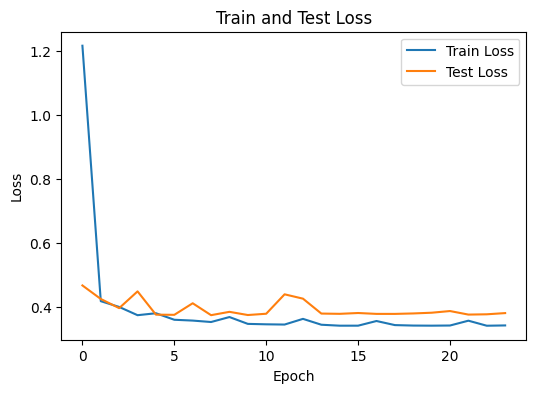

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(train_loss_history, label='Train Loss')
ax.plot(test_loss_history, label='Test Loss')

# Set labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train and Test Loss')

ax.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(train_loss_history))), y=train_loss_history, name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(len(test_loss_history))), y=test_loss_history, name='Test Loss'))

fig.update_layout(xaxis_title='Epoch')
fig.update_layout(yaxis_title='Loss')

fig.update_layout(title_text='Train and Test Loss')
fig.show()


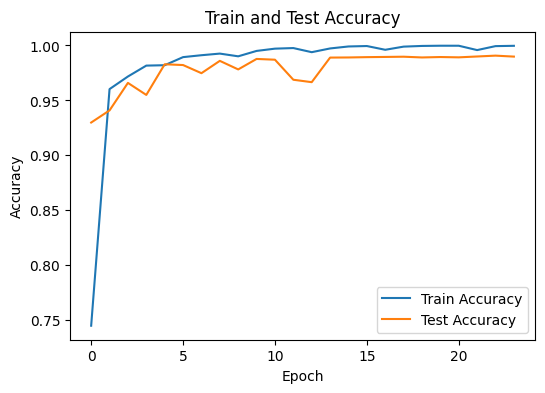

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(train_accuracy_history, label='Train Accuracy')
ax.plot(test_accuracy_history, label='Test Accuracy')

# Set labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracy')

ax.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(train_accuracy_history))), y=train_accuracy_history, name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(test_accuracy_history))), y=test_accuracy_history, name='Test Accuracy'))

fig.update_layout(xaxis_title='Epoch')
fig.update_layout(yaxis_title='Accuracy')

fig.update_layout(title_text='Train and Test Accuracy')
fig.show()


## Predictions

In [ ]:
for images, labels in train_loader:
  images, labels=images.to(device), labels.to(device)
  sample=images[0].unsqueeze(0)
  outputs=model(sample)
  _, predictions= torch.max(outputs.data, 1)
  print("Label: ",labels[0].item())
  print("Prediction: ",predictions.item())
  break

Label:  6
Prediction:  6


## Tensorflow Like Style for Training Loss and Accuracy

In [ ]:
print(f"Epoch {epoch+1}/{num_epochs} - Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item()}\r", end='')

In [ ]:
import time
for i in range(10):
  print(f"{i}",end='')
  time.sleep(0.7)
  print("\r",end='')

## Saving Model

In [ ]:
torch.save(model.state_dict(),'model.pt')

## Loading Model

# DUMPSTER


## Imp Random

In [ ]:
    # def forward(self,x):
    #   xb=xb.reshape(-1,784)
    #   out=self.linear(xb)
    #   return out

    # def training_step(self,batch):
    #   images,labels=batch
    #   outputs=self(images)
    #   loss=F.cross_entropy(outputs,labels)
    #   return loss

    # def validation_step(self,batch):
    #   images, labels=batch
    #   out=self(images)
    #   loss=F.cross_entropy(outputs,labels)
    #   acc=accuracy(outputs,labels)
    #   return {'val_loss':loss,'val_acc':acc}


# for parameter in model.parameters():
# print(parameter.shape
# model.linear1
# model.linear2
# model.activation
# model.softmax


In [ ]:
 model.linear1

In [ ]:
x=[1,2,3,4,5,6,7,8,9,10]
x_square=[sample**2 for sample in x]
x_square

In [ ]:
# Validation
def evaluate(model,val_loader):
  outputs=[models.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
# Training, Val, Test Loop
for epoch in range(100):
  for features, labels in train_loader:
    features, labels = features.to(device), labels.to(device)
    predictions=model(features)
    loss=loss_function(predictions,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Best Practices

In [ ]:
# https://www.youtube.com/watch?v=O2wJ3tkc-TU
# https://www.youtube.com/watch?v=2AhiHV7QGVk

## Transfer Learning and HyperParameter Training

In [ ]:
# https://www.youtube.com/watch?v=qaDe0qQZ5AQ

In [ ]:
torch.min(image).item()

## Custom Activation Function, Loss Function, Optimzer:

In [ ]:
# Custom Optimizer:
# https://www.youtube.com/watch?v=zvp8K4iX2Cs&pp=ygUUY3VzdG9tIG1vZGVsIHB5dG9yY2g%3D

In [ ]:
# https://www.youtube.com/watch?v=SDPeeX6LEnk []
# https://www.youtube.com/watch?v=OIenNRt2bjg []
# https://www.youtube.com/watch?v=H69j69FFMV0 [Dataset Spli First, then Data Loader]
# https://www.youtube.com/watch?v=SDPeeX6LEnk

In [ ]:
from torch import nn

class MyModel(nn.Module):
  def __init__(self): #Initializing the MyModel Class
    super().__init__() #Calling The Parent Class


## Other Dumpster

In [ ]:
data=torch.tensor([1,2,3,4,5])
print(data)
print(data.shape)

In [ ]:
#Tensor Gradients
x=torch.tensor(3.)
w=torch.tensor(4.,requires_grad=True)
b=torch.tensor(5.,requires_grad=True)

In [ ]:
# Calculate the value of y
y=x*w+b
y

In [ ]:
data=torch.full((3,3),101)
data

In [ ]:
#Converts numpy array to tensor
import numpy as np
x=np.ones((3,2))
y=torch.from_numpy(x)
x.dtype, y.dtype
# Internally both are the same

In [ ]:
# Convert Tensor to numpy
x=torch.ones((3,2))
y=x.numpy()
x.dtype, y.dtype

In [ ]:
# Find the number of element in a tensor
x.numel()

In [ ]:
# if gradient +ve:
#   increasing the weight value increases loss
#   decreasing the weight value decreases loss

# if gradient -ve:
#   increasing the weight value decreases loss
#   decreasing the weight value increases loss

In [ ]:
value=value-stepsize
value=value-lr*slope
value=value-lr*gradient
value=value-lr*derivative

In [ ]:
import torch.nn.functional as F
loss_func=F.mse_loss
loss=loss_func(model(input),labels)

In [ ]:
# optimizers perform the gradient descent, that is they adjust the weights and biases of parameters
optim=torch.optim.SGD(model.parameters,lr=1e-5)

In [ ]:
# def fit(num_epochs,model,loss_func,optim,train):
for epoch in range(num_epochs):
  for x,y in train:
    prediction=model(x)
    loss=loss_func(prediction,y)
    loss.backward()

    # Optimizer performs gradient descent and updates the Weights and Biases of Features/Parameters
    optim.step()

    # Reset the gradients for next epoch
    optim.zero_grad()

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [ ]:
# Transforms are used for handling image data one such usage is ToTensor() function

In [ ]:
# Random split in Pytorch
from torch.utils.data import random_split
train_ds, val_ds - random_split(dataset, [50000, 10000])
len (train_ds), len(val_ds)

In [ ]:
# Dataloader
from torch.utils.data import DataLoader
batch_size=128
train_loader=DataLoader(train_data,batch_size,shuffle=True) #Shuffle=True so that with each epoch the batches are not send in the same order, this helps to generalize model better
val_loader=DataLoader(val_data,batch_size)

In [ ]:
# Models
images.reshape(128,784)
model.parameters()
model.linear.weights.shape
model.linear.bias.shape

In [ ]:
import pandas as pd
import numpy as np
numbers = np.arange(1, 21)
labels = np.random.randint(0, 2, size=20)
df = pd.DataFrame({'Numbers': numbers, 'Labels': labels})
df

In [ ]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1:]

In [ ]:
import torch
predicted_labels = torch.tensor([1, 2, 3, 4])
  # Example predicted labels
ground_truth_labels = torch.tensor([1, 2, 4, 4])
  # Example ground truth labels

correct = (predicted_labels == ground_truth_labels).sum().item()
total = len(predicted_labels)
train_accuracy_per_epoch = correct / total
# print(f"Accuracy: {accuracy}")
train_accuracy_per_epoch*100

75.0